# Continuous Wavelet Transform (CWT) Analysis

This notebook performs Continuous Wavelet Transform analysis on EEG data for Alzheimer's disease classification.

## Key Features

### 1. CWT Generation
- Applies Morlet wavelets to EEG signals
- Multi-scale time-frequency decomposition
- Preserves temporal and spectral information

### 2. Scalogram Visualization
- Time-frequency representations of EEG signals
- Visual analysis of brain activity patterns
- Comparison between different conditions

### 3. Feature Extraction
- Statistical features from CWT coefficients
- Frequency band-specific analysis
- Channel-wise feature computation

### 4. Data Preprocessing
- Train/test splitting with stratification
- Subject-level data organization
- Feature matrix preparation for ML models

## Applications
- Time-frequency pattern recognition
- Transient event detection in EEG
- Multi-resolution analysis of brain signals
- Input features for CNN-based classification models

## Output
- CWT coefficient matrices for each subject
- Scalogram visualizations
- Extracted features ready for machine learning

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pywt

# List available input files
print("Available input files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/open-nuro-dataset/dataset/README
/kaggle/input/open-nuro-dataset/dataset/dataset_description.json
/kaggle/input/open-nuro-dataset/dataset/participants.json
/kaggle/input/open-nuro-dataset/dataset/participants.tsv
/kaggle/input/open-nuro-dataset/dataset/CHANGES
/kaggle/input/open-nuro-dataset/dataset/sub-060/eeg/sub-060_task-eyesclosed_eeg.set
/kaggle/input/open-nuro-dataset/dataset/sub-060/eeg/sub-060_task-eyesclosed_channels.tsv
/kaggle/input/open-nuro-dataset/dataset/sub-060/eeg/sub-060_task-eyesclosed_eeg.json
/kaggle/input/open-nuro-dataset/dataset/sub-003/eeg/sub-003_task-eyesclosed_eeg.set
/kaggle/input/open-nuro-dataset/dataset/sub-003/eeg/sub-003_task-eyesclosed_channels.tsv
/kaggle/input/open-nuro-dataset/dataset/sub-003/eeg/sub-003_task-eyesclosed_eeg.json
/kaggle/input/open-nuro-dataset/dataset/sub-012/eeg/sub-012_task-eyesclosed_channels.tsv
/kaggle/input/open-nuro-dataset/dataset/sub-012/eeg/sub-012_task-eyesclosed_eeg.json
/kaggle/input/open-nuro-dataset/dat

In [ ]:
# Load participant information
subjects_info = pd.read_csv('/kaggle/input/open-nuro-dataset/dataset/participants.tsv', delimiter='\t')
print("Loaded subject information:")
print(f"Total subjects: {len(subjects_info)}")
print(f"Groups: {subjects_info['Group'].unique()}")
print(f"Group distribution:\n{subjects_info['Group'].value_counts()}")

In [ ]:
from sklearn.model_selection import train_test_split

# Create stratified train/test splits maintaining group and gender balance
groups = subjects_info['Group'].unique()
train_dfs = []
test_dfs = []

print("Creating train/test splits for each group:")
for group in groups:
    group_df = subjects_info[subjects_info['Group'] == group]
    
    # Split while maintaining gender balance
    train_group, test_group = train_test_split(
        group_df, 
        test_size=0.3, 
        stratify=group_df['Gender'],
        random_state=42
    )
    
    train_dfs.append(train_group)
    test_dfs.append(test_group)
    
    print(f"Group {group}: {len(train_group)} train, {len(test_group)} test subjects")

# Combine splits
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

print(f"\nFinal split: {len(train_df)} train, {len(test_df)} test subjects")

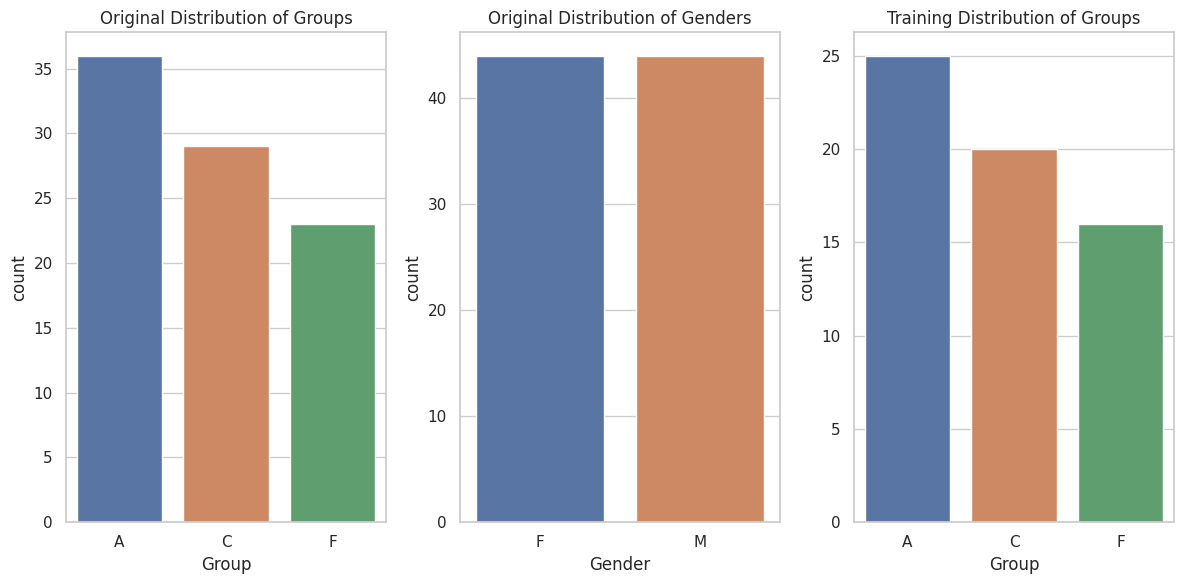

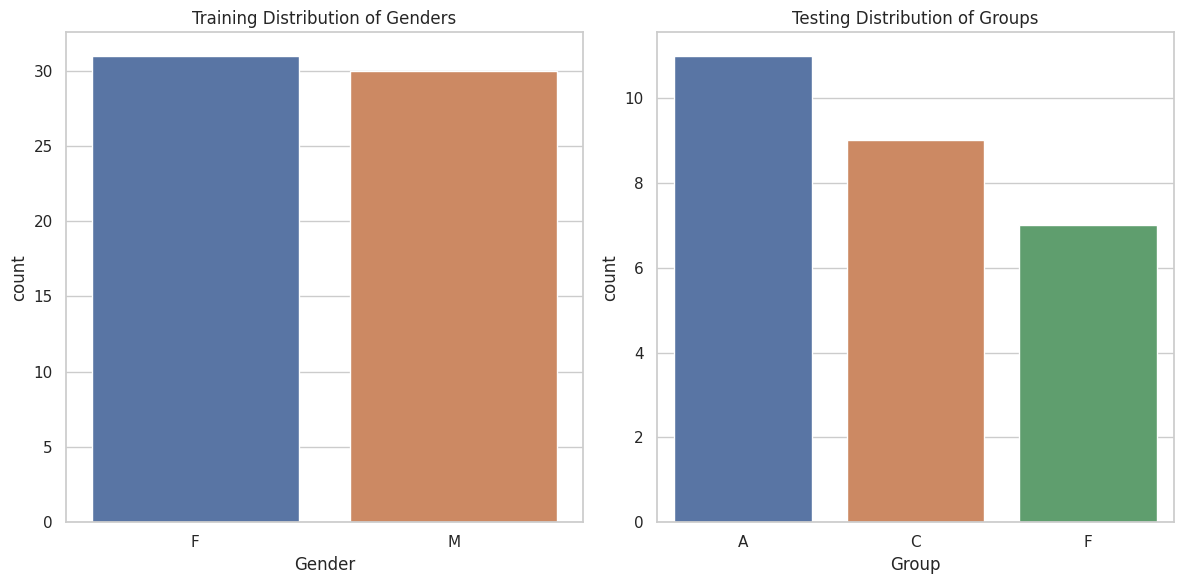

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Plot the distribution of groups in the original DataFrame
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.countplot(x='Group', data=subjects_info)
plt.title('Original Distribution of Groups')

# Plot the distribution of genders in the original DataFrame
plt.subplot(1, 3, 2)
sns.countplot(x='Gender', data=subjects_info)
plt.title('Original Distribution of Genders')

# Plot the distribution of groups in the training DataFrame
plt.subplot(1, 3, 3)
sns.countplot(x='Group', data=train_df)
plt.title('Training Distribution of Groups')

plt.tight_layout()
plt.show()

# Plot the distribution of genders in the training DataFrame
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Gender', data=train_df)
plt.title('Training Distribution of Genders')

# Plot the distribution of groups in the testing DataFrame
plt.subplot(1, 2, 2)
sns.countplot(x='Group', data=test_df)
plt.title('Testing Distribution of Groups')

plt.tight_layout()
plt.show()


In [5]:
# Extracting subject IDs from the training set
training_subjects = train_df['participant_id'].str.extract(r'sub-(\d+)').astype(int).squeeze().unique().tolist()

# Extracting subject IDs from the testing set
testing_subjects = test_df['participant_id'].str.extract(r'sub-(\d+)').astype(int).squeeze().unique().tolist()

# Displaying the lists of subjects
print("Training Subjects:")
print(training_subjects)

print("\nTesting Subjects:")
print(testing_subjects)


Training Subjects:
[1, 20, 11, 23, 26, 5, 33, 16, 30, 25, 24, 6, 21, 14, 34, 15, 2, 32, 29, 9, 13, 18, 12, 35, 19, 61, 48, 62, 49, 47, 58, 46, 45, 59, 50, 57, 43, 65, 54, 38, 53, 52, 51, 64, 56, 81, 86, 73, 79, 77, 70, 68, 88, 78, 76, 69, 71, 66, 75, 87, 74]

Testing Subjects:
[36, 3, 10, 4, 17, 22, 28, 27, 31, 7, 8, 37, 41, 42, 44, 39, 55, 40, 60, 63, 72, 80, 84, 82, 83, 85, 67]


In [6]:
# Initialize empty lists to store epoch data and information data
training_data = []
testing_data = []
training_info = []
testing_info = []

# Concatenate training data
for subject_num in training_subjects:
    # Load epoch data
    epoch_filename = f"/kaggle/input/epochs-of-the-alzheimer-data/epochs_data/subject_{subject_num}.npy"
    epoch_data = np.load(epoch_filename)
    training_data.append(epoch_data)
    
    # Load information data
    info_filename = f"/kaggle/input/epochs-of-the-alzheimer-data/epochs_data/epochs_information_sub_{subject_num}.csv"
    info_data = pd.read_csv(info_filename)
    training_info.append(info_data)

# Concatenate testing data
for subject_num in testing_subjects:
    # Load epoch data
    epoch_filename = f"/kaggle/input/epochs-of-the-alzheimer-data/epochs_data/subject_{subject_num}.npy"
    epoch_data = np.load(epoch_filename)
    testing_data.append(epoch_data)
    
    # Load information data
    info_filename = f"/kaggle/input/epochs-of-the-alzheimer-data/epochs_data/epochs_information_sub_{subject_num}.csv"
    info_data = pd.read_csv(info_filename)
    testing_info.append(info_data)

# Concatenate all subject data along the first axis
training_data_concatenated = np.concatenate(training_data, axis=0)
testing_data_concatenated = np.concatenate(testing_data, axis=0)

# Concatenate all subject information
training_info_concatenated = pd.concat(training_info, ignore_index=True)
testing_info_concatenated = pd.concat(testing_info, ignore_index=True)


In [16]:
training_info_concatenated.shape

(1159, 5)

In [17]:
epoch_data.shape

(28, 19, 22500)

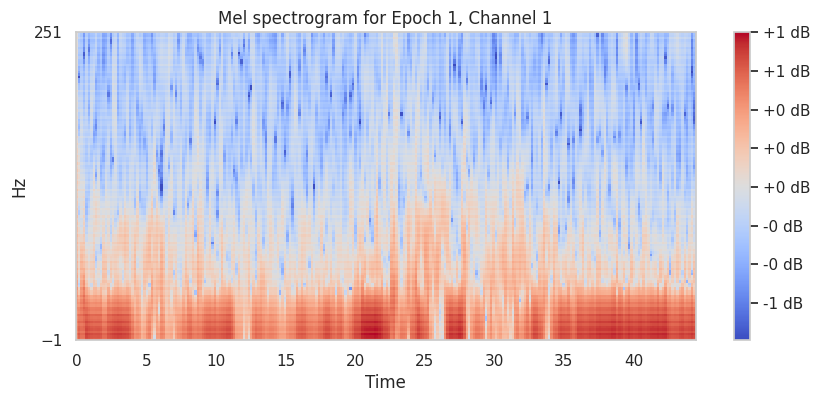

In [18]:
import numpy as np
import mne
import librosa
import matplotlib.pyplot as plt

# Load EEG data from npy file
eeg_data = np.load('/kaggle/input/epochs-of-the-alzheimer-data/epochs_data/subject_1.npy')

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Assuming eeg_data is your EEG data with shape (15, 19, 22500)

# Define parameters
n_fft = 2048  # FFT window size
hop_length = len(eeg_data[0, 0]) // 256  # Hop length
n_mels = 128  # Number of Mel bands
fmin = 0  # Minimum frequency
fmax = 20  # Maximum frequency
win_length = 256  # Window length

# Initialize an empty array to store Mel spectrograms
mel_spectrograms = np.zeros((15, 19, n_mels, 256))  # Adjust the last dimension according to your desired output shape

# Iterate over each epoch and each channel
for epoch in range(15):
    for channel in range(19):
        # Compute the spectrogram
        spec = librosa.feature.melspectrogram(y=eeg_data[epoch, channel], sr=500, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax, win_length=win_length)
        
        # Convert to dB scale
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_db=(spec_db+40)/40
        # Store in the mel_spectrograms array
        mel_spectrograms[epoch, channel] = spec_db[:, :256]  # Adjust slicing according to your desired output shape

# Visualize one of the Mel spectrograms
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrograms[0, 1], sr=500, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram for Epoch 1, Channel 1')
plt.show()

In [9]:
file_path = '/kaggle/input/epochs-of-the-alzheimer-data/epochs_data/subject_1.npy'
data = np.load(file_path)
data.shape

(19, 19, 22500)

In [20]:
data[1,1,:].shape

(22500,)

In [40]:
import numpy as np

# Delta (1–3 Hz)
delta = np.linspace(0.5, 3, 50)

# Theta (4–7 Hz)
theta = np.linspace(4, 7, 20)

# Alpha (8–12 Hz)
alpha = np.linspace(8, 12, 20)

# Beta (13–30 Hz)
beta = np.linspace(13, 30, 20)

# Gamma (30–100 Hz)
gamma = np.linspace(30, 100, 2)

all_delta = np.concatenate([delta, theta, alpha, beta, gamma])
all_delta=np.flip(all_delta)

In [51]:
import numpy as np
import pywt
dt = 0.002  # 500 Hz sampling
fs = 1 / dt
frequencies = np.array([0.2, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38])
frequencies = all_delta / fs # normalize
scale = pywt.frequency2scale('morl', frequencies)
scale


array([  4.0625    ,  13.54166667,  13.54166667,  13.9579566 ,
        14.40065299,  14.87235067,  15.37599602,  15.91494845,
        16.49305556,  17.11474501,  17.78513825,  18.51019185,
        19.296875  ,  20.15339426,  21.08948087,  22.11676218,
        23.24924699,  24.50396825,  25.90184564,  27.46886121,
        29.23768939,  31.25      ,  33.85416667,  34.45870536,
        35.08522727,  35.7349537 ,  36.40919811,  37.109375  ,
        37.8370098 ,  38.59375   ,  39.38137755,  40.20182292,
        41.05718085,  41.94972826,  42.88194444,  43.85653409,
        44.87645349,  45.94494048,  47.06554878,  48.2421875 ,
        49.47916667,  50.78125   ,  58.03571429,  59.375     ,
        60.77755906,  62.24798387,  63.79132231,  65.41313559,
        67.11956522,  68.91741071,  70.81422018,  72.81839623,
        74.93932039,  77.1875    ,  79.57474227,  82.1143617 ,
        84.82142857,  87.71306818,  90.80882353,  94.13109756,
        97.7056962 , 101.5625    , 135.41666667, 137.75

In [27]:
f = pywt.scale2frequency("mexh", scale)/0.002
f

array([ 0.15384615,  0.19433198,  0.23481781,  0.27530364,  0.31578947,
        0.3562753 ,  0.39676113,  0.43724696,  0.47773279,  0.51821862,
        0.55870445,  0.59919028,  0.63967611,  0.68016194,  0.72064777,
        0.7611336 ,  0.80161943,  0.84210526,  0.88259109,  0.92307692,
        1.23076923,  1.27935223,  1.32793522,  1.37651822,  1.42510121,
        1.47368421,  1.52226721,  1.5708502 ,  1.6194332 ,  1.66801619,
        1.71659919,  1.76518219,  1.81376518,  1.86234818,  1.91093117,
        1.95951417,  2.00809717,  2.05668016,  2.10526316,  2.15384615,
        2.46153846,  2.52631579,  2.59109312,  2.65587045,  2.72064777,
        2.7854251 ,  2.85020243,  2.91497976,  2.97975709,  3.04453441,
        3.10931174,  3.17408907,  3.2388664 ,  3.30364372,  3.36842105,
        3.43319838,  3.49797571,  3.56275304,  3.62753036,  3.69230769,
        4.        ,  4.27530364,  4.55060729,  4.82591093,  5.10121457,
        5.37651822,  5.65182186,  5.92712551,  6.20242915,  6.47

In [12]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

/opt/conda/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


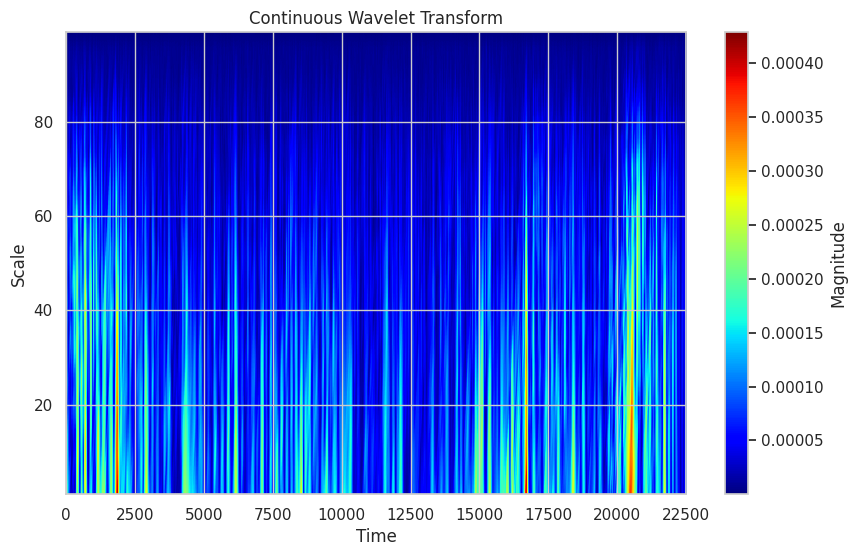

In [13]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Assuming data is your EEG signal
# data.shape should be (n_samples,)
# You may need to adjust the parameters according to your data and requirements

# Define wavelet parameters
wavelet = 'cmor'  # Morlet wavelet is commonly used for EEG analysis
scales = np.arange(1, 100)  # Scales for the CWT

# Perform Continuous Wavelet Transform
coefficients, frequencies = pywt.cwt(data[1, 1, :], scales, wavelet)
#coefficients=librosa.power_to_db(coefficients)
# Plot the CWT coefficients
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), extent=[0, len(data[4, 10, :]), scales[0], scales[-1]], aspect='auto', cmap='jet')

plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()


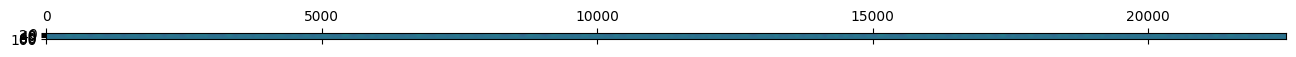

In [23]:
# Convert scales to frequencies
sampling_period = 0.002  # assume a sampling period of 1
frequencies = pywt.scale2frequency(wavelet, scale) / sampling_period

# Plot the coefficients matrix
plt.matshow(coefficients)
plt.show()

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Loop over each subject
for subject_id in range(1, 89):  # Assuming subjects are numbered from 1 to 88
    # Load EEG data from npy file
    eeg_data = np.load(f'/kaggle/input/epochs-of-the-alzheimer-data/epochs_data/subject_{subject_id}.npy')

    # Define parameters
    n_fft = 2048  # FFT window size
    hop_length = len(eeg_data[0, 0]) // 256  # Hop length
    n_mels = 128  # Number of Mel bands
    fmin = 0  # Minimum frequency
    fmax = 20  # Maximum frequency
    win_length = 256  # Window length

    # Initialize an empty array to store Mel spectrograms
    mel_spectrograms = np.zeros((eeg_data.shape[0], eeg_data.shape[1], n_mels, 256))  # Adjust the last dimension according to your desired output shape

    # Iterate over each epoch and each channel
    for epoch in range(eeg_data.shape[0]):
        for channel in range(eeg_data.shape[1]):
            # Compute the spectrogram
            spec = librosa.feature.melspectrogram(y=eeg_data[epoch, channel], sr=500, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax, win_length=win_length)
            
            # Convert to dB scale
            spec_db = librosa.power_to_db(spec, ref=np.max)
            spec_db = (spec_db + 40) / 40
            
            # Store in the mel_spectrograms array
            mel_spectrograms[epoch, channel] = spec_db[:, :256]  # Adjust slicing according to your desired output shape

    # Save the Mel spectrograms for the current subject
    np.save(f'subject_{subject_id}_mel_spectrograms.npy', mel_spectrograms)

    # Optionally, visualize and save plots
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrograms[0, 1], sr=500, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram for Epoch 1, Channel 1 (Subject {subject_id})')
    plt.savefig(f'subject_{subject_id}_mel_spectrogram.png')
    plt.close()


In [26]:
eeg_data.shape

(19, 19, 22500)

In [68]:
# From https://github.com/tomrunia/PyTorchWavelets/blob/master/wavelets_pytorch/wavelets.py

## from G2net1 
import torch
from scipy import signal
from scipy import optimize
import torch.nn as nn
from timm.layers.conv2d_same import conv2d_same

class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4.0 * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -0.25 * Hw * np.exp((-((x - self.w0) ** 2)) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s


class CWT(nn.Module):
    def __init__(
        self,
        dj=0.0625,
        dt=1 / 500,
        wavelet=Morlet(),
        fmin: int = 1,
        fmax: int = 500,
        output_format="Magnitude",
        trainable=False,
        hop_length: int = 1,
    ):
        super().__init__()
        self.wavelet = wavelet

        self.dt = dt
        self.dj = dj
        self.fmin = fmin
        self.fmax = fmax
        self.output_format = output_format
        self.trainable = trainable  # TODO make kernel a trainable parameter
        self.stride = (1, hop_length)
        # self.padding = 0  # "same"

        self._scale_minimum = self.compute_minimum_scale()

        self.signal_length = None
        self._channels = None

        self._scales = None
        self._kernel = None
        self._kernel_real = None
        self._kernel_imag = None

    def compute_optimal_scales(self):
        """
        Determines the optimal scale distribution (see. Torrence & Combo, Eq. 9-10).
        :return: np.ndarray, collection of scales
        """
        if self.signal_length is None:
            raise ValueError(
                "Please specify signal_length before computing optimal scales."
            )
        J = int(
            (1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum)
        )
        scales = self._scale_minimum * 2 ** (self.dj * np.arange(0, J + 1))

        # Remove high and low frequencies
        frequencies = np.array([1 / self.wavelet.fourier_period(s) for s in scales])
        if self.fmin:
            frequencies = frequencies[frequencies >= self.fmin]
            scales = scales[0 : len(frequencies)]
        if self.fmax:
            frequencies = frequencies[frequencies <= self.fmax]
            scales = scales[len(scales) - len(frequencies) : len(scales)]

        return scales

    def compute_minimum_scale(self):
        """
        Choose s0 so that the equivalent Fourier period is 2 * dt.
        See Torrence & Combo Sections 3f and 3h.
        :return: float, minimum scale level
        """
        dt = self.dt

        def func_to_solve(s):
            return self.wavelet.fourier_period(s) - 2 * dt

        return optimize.fsolve(func_to_solve, 1)[0]

    def _build_filters(self):
        self._filters = []
        for scale_idx, scale in enumerate(self._scales):
            # Number of points needed to capture wavelet
            M = 10 * scale / self.dt
            # Times to use, centred at zero
            t = torch.arange((-M + 1) / 2.0, (M + 1) / 2.0) * self.dt
            if len(t) % 2 == 0:
                t = t[0:-1]  # requires odd filter size
            # Sample wavelet and normalise
            norm = (self.dt / scale) ** 0.5
            filter_ = norm * self.wavelet(t, scale)
            self._filters.append(torch.conj(torch.flip(filter_, [-1])))

        self._pad_filters()

    def _pad_filters(self):
        filter_len = self._filters[-1].shape[0]
        padded_filters = []

        for f in self._filters:
            pad = (filter_len - f.shape[0]) // 2
            padded_filters.append(nn.functional.pad(f, (pad, pad)))

        self._filters = padded_filters

    def _build_wavelet_bank(self):
        """This function builds a 2D wavelet filter using wavelets at different scales

        Returns:
            tensor: Tensor of shape (num_widths, 1, channels, filter_len)
        """
        self._build_filters()
        wavelet_bank = torch.stack(self._filters)
        wavelet_bank = wavelet_bank.view(
            wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1]
        )
        # See comment by tez6c32
        # https://www.kaggle.com/anjum48/continuous-wavelet-transform-cwt-in-pytorch/comments#1499878
        # wavelet_bank = torch.cat([wavelet_bank] * self.channels, 2)
        return wavelet_bank

    def forward(self, x):
        """Compute CWT arrays from a batch of multi-channel inputs

        Args:
            x (torch.tensor): Tensor of shape (batch_size, channels, time)

        Returns:
            torch.tensor: Tensor of shape (batch_size, channels, widths, time)
        """
        if self.signal_length is None:
            self.signal_length = x.shape[-1]
            self.channels = x.shape[-2]
            self._scales = self.compute_optimal_scales()
            self._kernel = self._build_wavelet_bank()

            if self._kernel.is_complex():
                self._kernel_real = self._kernel.real
                self._kernel_imag = self._kernel.imag

        x = x.unsqueeze(1)
        if self._kernel.is_complex():
            if (
                x.dtype != self._kernel_real.dtype
                or x.device != self._kernel_real.device
            ):
                self._kernel_real = self._kernel_real.to(device=x.device, dtype=x.dtype)
                self._kernel_imag = self._kernel_imag.to(device=x.device, dtype=x.dtype)

            # Strides > 1 not yet supported for "same" padding
            # output_real = nn.functional.conv2d(
            #     x, self._kernel_real, padding=self.padding, stride=self.stride
            # )
            # output_imag = nn.functional.conv2d(
            #     x, self._kernel_imag, padding=self.padding, stride=self.stride
            # )
            output_real = conv2d_same(x, self._kernel_real, stride=self.stride)
            output_imag = conv2d_same(x, self._kernel_imag, stride=self.stride)
            output_real = torch.transpose(output_real, 1, 2)
            output_imag = torch.transpose(output_imag, 1, 2)

            if self.output_format == "Magnitude":
                return torch.sqrt(output_real ** 2 + output_imag ** 2)
            else:
                return torch.stack([output_real, output_imag], -1)

        else:
            if x.device != self._kernel.device:
                self._kernel = self._kernel.to(device=x.device, dtype=x.dtype)

            # output = nn.functional.conv2d(
            #     x, self._kernel, padding=self.padding, stride=self.stride
            # )
            output = conv2d_same(x, self._kernel, stride=self.stride)
            return torch.transpose(output, 1, 2)

In [28]:
data.shape

(42, 19, 22500)

In [75]:
S = torch.tensor(data[30,2,:])[None,:]
pycwt = CWT(fmin=0, fmax=40, hop_length=22500//512)

In [53]:
data.shape

(42, 19, 22500)

In [54]:
cwt_img = np.zeros((166,527,4),dtype='float32')
cwt_img1 = np.zeros((166,527,4),dtype='float32')

In [55]:
S.shape

torch.Size([1, 22500])

In [76]:
out = pycwt(S).numpy()
out1 = librosa.power_to_db(out, ref=np.max).astype(np.float32)
out1 = (out1+40)/40 


NameError: name 'librosa' is not defined

In [ ]:
out.shape

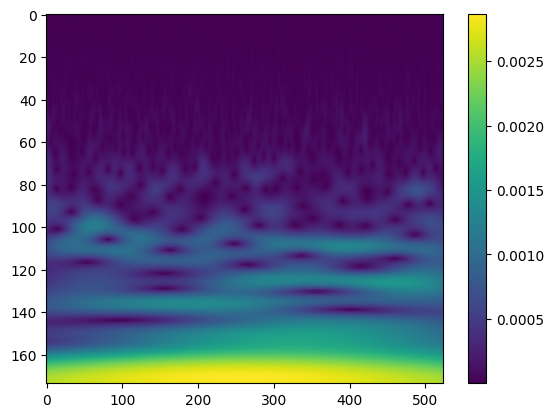

In [77]:
import matplotlib.pyplot as plt

# Assuming 'out' is your image data
plt.imshow(out, aspect="auto")
plt.colorbar()  # Add colorbar
plt.show()


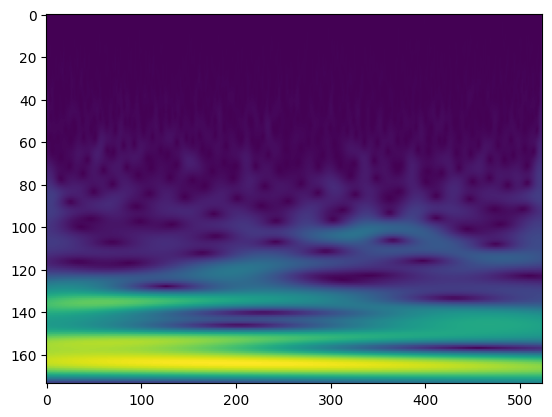

In [74]:
plt.imshow(out, aspect="auto")

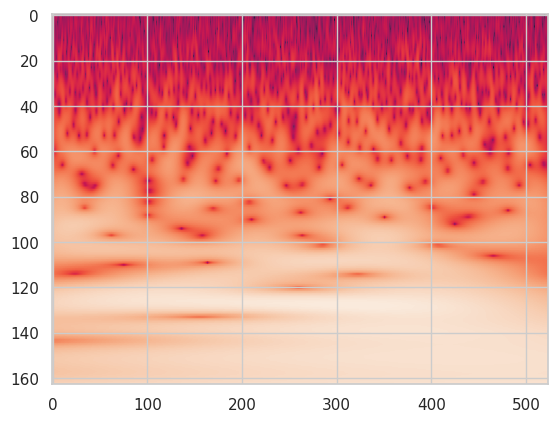

In [45]:
plt.imshow(out1, aspect="auto")

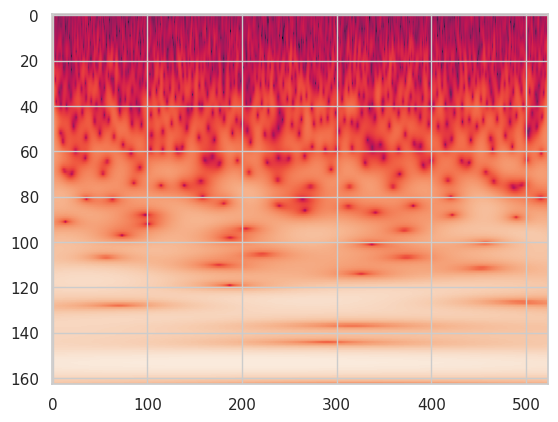

In [59]:
plt.imshow(out1, aspect="auto")